In [51]:
import arrow
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import PrepareSolar as PS

In [192]:
vsmall = 1e-4

In [134]:
reload(PS)

<module 'PrepareSolar' from '/ocean/sallen/allen/research/Meopar/ANALYSIS/analysis-armaan/notebooks/PrepareSolar.py'>

In [2]:
year = 2007
month = 11
day = 5

In [3]:
threehour = xr.open_dataset(f'ncfiles/vectoravg_y{year}m{month}d{day:02d}.nc')
threehour

<xarray.Dataset>
Dimensions:       (time_counter: 8, x: 256, y: 266)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2007-11-05T01:30:00 ... 2007-...
  * y             (y) int64 0 1 2 3 4 5 6 7 ... 258 259 260 261 262 263 264 265
  * x             (x) int64 0 1 2 3 4 5 6 7 ... 248 249 250 251 252 253 254 255
Data variables:
    u_wind        (time_counter, y, x) float64 ...
    v_wind        (time_counter, y, x) float64 ...
    solar         (time_counter, y, x) float64 ...
    tair          (time_counter, y, x) float64 ...
    precip        (time_counter, y, x) float64 ...
    atmpres       (time_counter, y, x) float64 ...
    qair          (time_counter, y, x) float64 ...
    therm_rad     (time_counter, y, x) float64 ...
Attributes:
    Comment:  3hr avg files

In [15]:
# get lats and lons
basefile = xr.open_dataset(f'/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y{year}m{month}d{day:02d}.nc')
lons, lats = basefile.nav_lon.values, basefile.nav_lat.values
basefile.close()

In [132]:
starttime = arrow.get(year, month, day, 0, 0, 0) # to match hrdps, see below
endtime = arrow.get(year, month, day+2, 0, 0, 0)
deltat = arrow.get(year, month, day, 0, 10, 0) - arrow.get(year, month, day, 0, 0, 0)

In [168]:
solar = np.zeros((int(86400*2/10/60), len(threehour.y), len(threehour.x)))
times = np.zeros(solar.shape[0]).astype('datetime64[s]')
time = starttime
ii = 0
while time < endtime:
    hour = time.hour + time.minute/60.
    yearday = int(time.format('DDDD'))
    solar[ii] = PS.gen_solar(hour, yearday, lats, lons, offset=-1.)
    times[ii] = time.naive
    ii = ii + 1
    time = time + deltat

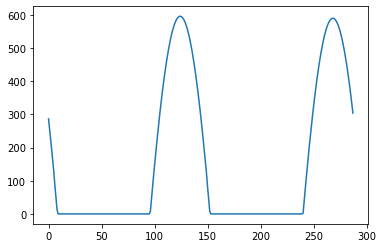

In [169]:
plt.plot(solar[:, 100, 100])

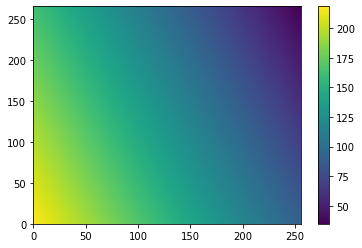

In [170]:
plt.pcolormesh(solar[100])
plt.colorbar()

In [171]:
da_solar = xr.DataArray(
    data=solar,
    dims=['time', 'y', 'x'],
    coords=dict(
        time=times,
    ),

    attrs=dict(
        description="Max Solar",
        units="W/m2",
    ),

)

## next problem: aligning the time.  

Let's play with one hour to do that.
Adding one hour offset above seems to work

In [ ]:
raw = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2007m11d05.nc')
raw2 = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2007m11d06.nc')

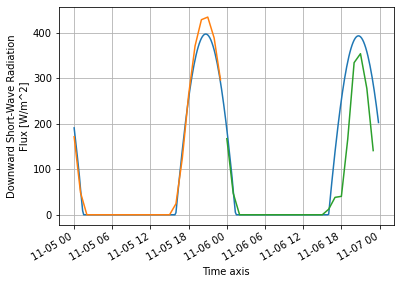

In [172]:
(da_solar[:, 100, 100]/1.5).plot()
raw.solar[:, 100, 100].plot()
raw2.solar[:, 100, 100].plot()
plt.grid();

In [139]:
maxsolar_1h = da_solar.resample(time='1h', loffset=('30min')).mean() 

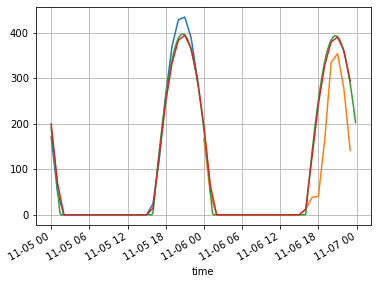

In [176]:
raw.solar[:, 100, 100].plot()
raw2.solar[:, 100, 100].plot()
(da_solar[:, 100, 100]/1.5).plot()
(maxsolar_1h[:, 100, 100]/1.5).plot()
plt.grid();

In [130]:
maxsolar_3h = da_solar.resample(time='3h', loffset=('90min')).mean()

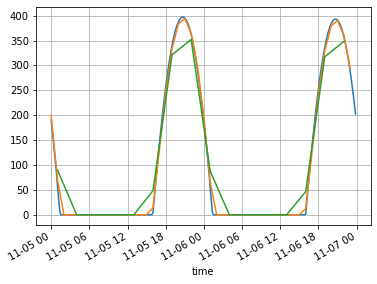

In [178]:
(da_solar[:, 100, 100]/1.5).plot()
(maxsolar_1h[:, 100, 100]/1.5).plot()
(maxsolar_3h[:, 100, 100]/1.5).plot()
plt.grid();

In [184]:
da_solar[:, 100, 100].sum().values/48./6.

150.89949870523478

In [183]:
maxsolar_1h[:, 100, 100].sum().values/48.

151.02014698336524

In [185]:
maxsolar_3h[:, 100, 100].sum().values/16.

151.02014698336524

## Now Getting it Back from 3 hour Solar

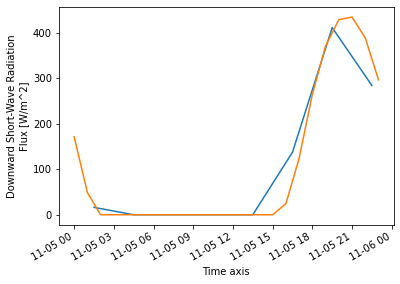

In [218]:
threehour.solar[:, 100, 100].plot()
raw.solar[:, 100, 100].plot()

In [219]:
# Crikey, looks like I corrected the time scale of the three hour solar!

In [220]:
ndays = 1
starttime = arrow.get(year, month, day, 0, 0, 0) # to match hrdps, see below
endtime = arrow.get(year, month, day+ndays, 0, 0, 0)
solar = np.zeros((int(86400*ndays/10/60), len(threehour.y), len(threehour.x)))
times = np.zeros(solar.shape[0]).astype('datetime64[s]')
time = starttime
ii = 0
while time < endtime:
    hour = time.hour + time.minute/60.
    yearday = int(time.format('DDDD'))
    solar[ii] = PS.gen_solar(hour, yearday, lats, lons, offset=0)
    times[ii] = time.naive
    ii = ii + 1
    time = time + deltat

In [226]:
da_solar = xr.DataArray(
    data=solar,
    dims=['time', 'y', 'x'],
    coords=dict(
        time=times,
    ),

    attrs=dict(
        description="Max Solar",
        units="W/m2",
    ),

)

In [227]:
maxsolar_1h = da_solar.resample(time='1h', loffset=('30min')).mean() 

In [228]:
maxsolar_3h = da_solar.resample(time='3h', loffset=('90min')).mean()

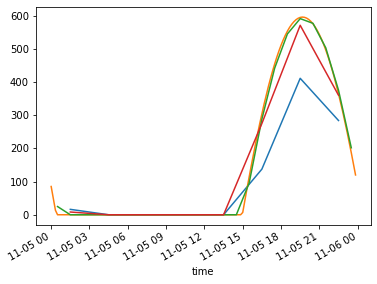

In [238]:
threehour.solar[:, 100, 100].plot()
da_solar[:, 100, 100].plot()
maxsolar_1h[:, 100, 100].plot()
maxsolar_3h[:, 100, 100].plot()

In [230]:
ratio = np.array(threehour.solar[:, 100, 100]) / (np.array(maxsolar_3h[0:8, 100, 100]) + vsmall)

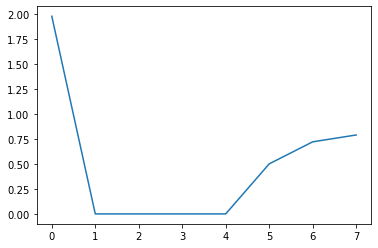

In [231]:
plt.plot(ratio);

In [232]:
ratio[ratio > 1] = 1

In [234]:
myvalues = np.empty_like(maxsolar_1h[:, 100, 100])

In [235]:
myvalues[0::3] = ratio * maxsolar_1h[0::3, 100, 100]
myvalues[1::3] = ratio * maxsolar_1h[1::3, 100, 100]
myvalues[2::3] = ratio * maxsolar_1h[2::3, 100, 100]

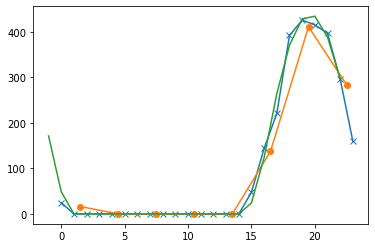

In [241]:
plt.plot(myvalues, 'x-')
plt.plot(1.5+np.arange(0, 24, 3), threehour.solar[:, 100, 100], 'o-')
plt.plot(np.arange(-1, 23, 1), raw.solar[:, 100, 100])
#plt.plot(np.arange(0, 24, 1/6.), da_solar[:6*24, 100, 100])

Yes, this works!  I can do day by day.  Issues to check:  
working on multi-dimensional arrays rather than a single point.

In [242]:
myvalues.shape

(24,)

In [243]:
ratio = np.array(threehour.solar[:, :, :]) / (np.array(maxsolar_3h[0:8, :, :]) + vsmall)

In [244]:
ratio[ratio > 1] = 1

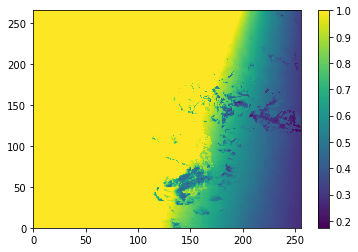

In [247]:
plt.pcolormesh(ratio[0])
plt.colorbar();

In [248]:
myvalues = np.empty_like(maxsolar_1h[:, :, :])

In [249]:
myvalues[0::3] = ratio * maxsolar_1h[0::3]
myvalues[1::3] = ratio * maxsolar_1h[1::3]
myvalues[2::3] = ratio * maxsolar_1h[2::3]

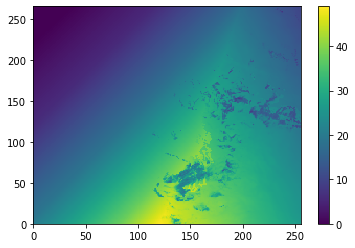

In [250]:
plt.pcolormesh(myvalues[0])
plt.colorbar();

In [251]:
# Loverly.